## 1.1 Setting up the dependencies

In [2]:
import time
import uuid #---> Used for getting specific uniform identifier
import os
import cv2

In [3]:
images_path = os.path.join('data','images')
number_images= 0

In [4]:
cap = cv2.VideoCapture(0)

for imagnum in range(number_images):
    print('collecting image {}'.format(imagnum))
    ret,frame = cap.read()
    imgname = os.path.join(images_path,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname,frame)
    cv2.imshow('frame',frame)
    time.sleep(0.5)

    
    if cv2.waitKey(1) & 0xFF == ord('q')    :
        break
cap.release()
cv2.destroyAllWindows()

## !.2 Annotate Images with Labels

In [4]:
!labelme


# 2. Review Dataset and Build Image Loading Function

In [5]:
import tensorflow as tf
import json
import numpy as np
import matplotlib.pyplot as plt


In [6]:
# For avoiding OOM errors by setting GPU Memory Consumption Growt
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus :
    tf.config.experimental.set_memory_growth(gpu,True)

In [7]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Metal device set to: Apple M1 Pro


True

In [8]:
images = tf.data.Dataset.list_files('data/images/*.jpg',shuffle=False)

In [9]:
images.as_numpy_iterator().next()

b'data/images/d4755528-1330-11ee-9b6c-da95c3cef8a9.jpg'

In [10]:
def load_image(x):
    byt_imag = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byt_imag)
    return img

In [11]:
images = images.map(load_image)

In [12]:
images.as_numpy_iterator().next()

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [13]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

## View Raw images as with matpllotlib

In [14]:
image_generator = images.batch(4).as_numpy_iterator()

In [15]:
plot_images = image_generator.next()

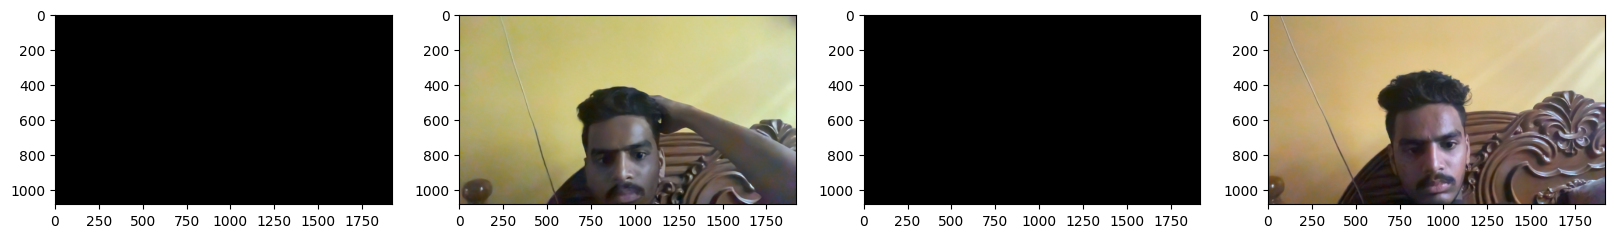

In [16]:
img,ax = plt.subplots(ncols=4,figsize=(20,20))
for idx,image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

# 3. Partition of Unaugumented Data

## 3.1 Manually split data into train val and test

In [17]:
126*0.7 # train 88

88.19999999999999

In [18]:
126*.15 # test - 19

18.9

In [19]:
# val 19

## 3.2 Move the matching labels

In [20]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data',folder,'images')):
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels',filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath,new_filepath)
            

# 4. Apply image Augumentaions on the images using the Albumentaions

## 4.1 Setup Albumentations Transform Pipeline

In [21]:
import albumentations as alb

In [22]:
# augmentor = alb.Compose([alb.RandomCrop(width=(450),height = 450),alb.HorizontalFlip (p=0.5),
#                          alb.RandomBrightnessContrast(p=0.2),alb.RandomGamma(p=0.2),
#                          alb.RGBShift(p=0.2),alb.VerticalFlip(p=0.2)],
#                          bbox_params = alb.BboxParams(format='albumentations',
#                                                      label_fields=['class_labels']))

augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

## 4.2 Load a Test image and Annotation with opencv and json

In [23]:
img = cv2.imread(os.path.join('data','train','images','17c3c022-11e6-11ee-9bb4-da95c3cef8a9.jpg'))

In [24]:
img

array([[[213, 232, 239],
        [215, 234, 241],
        [217, 236, 243],
        ...,
        [153, 187, 203],
        [134, 168, 184],
        [116, 150, 166]],

       [[216, 235, 242],
        [217, 236, 243],
        [218, 237, 244],
        ...,
        [152, 186, 202],
        [138, 172, 188],
        [124, 158, 174]],

       [[219, 238, 245],
        [219, 238, 245],
        [220, 239, 246],
        ...,
        [157, 191, 207],
        [150, 184, 200],
        [143, 177, 193]],

       ...,

       [[188, 207, 222],
        [188, 207, 222],
        [188, 207, 222],
        ...,
        [152, 174, 192],
        [146, 168, 186],
        [147, 169, 187]],

       [[183, 202, 217],
        [185, 204, 219],
        [187, 206, 221],
        ...,
        [148, 170, 188],
        [141, 163, 181],
        [143, 165, 183]],

       [[177, 196, 211],
        [181, 200, 215],
        [186, 205, 220],
        ...,
        [149, 171, 189],
        [146, 168, 186],
        [153, 175, 193]]

In [25]:
with open(os.path.join('data','train','labels','195aa540-11e6-11ee-9bb4-da95c3cef8a9.json'),'r') as f :
    label = json.load(f)

In [26]:
(label['shapes'][0]['label'])

'face'

## 4.3 Extract coordinates and rescale to match image resolution

In [27]:
coords = [0,0,0,0]

In [28]:
coords[0]= label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] =label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [29]:
coords ## ----> (x1,y1(Top coordinates),x2,y2(Bottom Cooordinates))

[726.3934426229508, 323.60655737704917, 1247.704918032787, 887.5409836065573]

In [30]:
x = cv2.imread('data/train/images/149364c0-11e6-11ee-9bb4-da95c3cef8a9.jpg') ## to check the shape of the images

In [31]:
x.shape

(1080, 1920, 3)

In [32]:
coords = list(np.divide(coords,[1920,1080,1920,1080])) ## _---> Dividing the image with the height of image and width of image 
# My webcam resolution is different so i am using the values 

In [33]:
coords

[0.37832991803278687,
 0.2996357012750455,
 0.6498463114754098,
 0.8217972070431087]

## 4.4 Apply Augumentations and view results

In [34]:
augumented = augmentor(image = img,bboxes =[coords],class_labels = ['face'])

In [35]:
augumented.keys()

dict_keys(['image', 'bboxes', 'class_labels'])

In [36]:
(augumented['bboxes'][0])

IndexError: list index out of range

In [37]:
cv2.rectangle(augumented['image'],
              tuple(np.multiply(augumented['bboxes'][0][:2], [1920, 1080]).astype(int)),
              tuple(np.multiply(augumented['bboxes'][0][2:], [1920, 1080]).astype(int)),
              (255, 0, 0), 2)

plt.imshow(augumented['image'])


IndexError: list index out of range

# 5. Build and Run Augumentation Pieline

In [38]:
## 5.1 Run Augumentation Pipeline

In [44]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords,[1920,1080,1920,1080]))

        try: 
            for x in range(60):
                augumented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.png'), augumented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augumented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augumented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

image must be numpy array type
image must be numpy array type
image must be numpy array type
image must be numpy array type


In [45]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.png', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [46]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.png', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [47]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.png', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [48]:
train_images.as_numpy_iterator().next()

array([[[0.8166054 , 0.76170343, 0.7185662 ],
        [0.8238358 , 0.76893383, 0.7257966 ],
        [0.82058823, 0.7656863 , 0.7147059 ],
        ...,
        [0.84313726, 0.7921569 , 0.7254902 ],
        [0.8392157 , 0.79607844, 0.7254902 ],
        [0.8392157 , 0.79607844, 0.7254902 ]],

       [[0.81911767, 0.7642157 , 0.7132353 ],
        [0.82003677, 0.7651348 , 0.7141544 ],
        [0.82303923, 0.77205884, 0.70931375],
        ...,
        [0.84313726, 0.7921569 , 0.7254902 ],
        [0.8392157 , 0.79607844, 0.7254902 ],
        [0.8392157 , 0.79607844, 0.7254902 ]],

       [[0.8156863 , 0.7607843 , 0.70980394],
        [0.81960785, 0.7647059 , 0.7137255 ],
        [0.82169116, 0.7667892 , 0.7158088 ],
        ...,
        [0.8396446 , 0.79650736, 0.71905637],
        [0.8392157 , 0.79607844, 0.7254902 ],
        [0.8292279 , 0.7978554 , 0.7233456 ]],

       ...,

       [[0.7882353 , 0.7137255 , 0.65882355],
        [0.7882353 , 0.7137255 , 0.65882355],
        [0.7848039 , 0

# 6. Prepare Labels

## 6.1 Build Label Loading Function

In [49]:
# def load_labels (label_path):
#     with open(label_path.numpy(),'r',encoding='utf-8') as f:
#         label = json.load(f)
#     return [label['class'], label['bbox']]
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [50]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json',shuffle=False)

In [51]:
train_labels.as_numpy_iterator().next()

b'aug_data/train/labels/12c92cf6-11eb-11ee-bd2f-da95c3cef8a9.0.json'

In [52]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [53]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [54]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [55]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.978 , 0.    , 1.    , 0.7944], dtype=float16))

# 7. Combine Labels and Image Samples

## 7.1 Create partitions

In [56]:
len(train_images),len(train_labels),len(test_images),len(test_labels),len(val_images),len(val_labels)

(5280, 5280, 1140, 1140, 1140, 1140)

## 7.2 create final dataset

In [57]:
train = tf.data.Dataset.zip(train_images,train_labels)
train = train.shuffle(6000)
train = train.batch(8)
train = train.prefetch(4)

In [58]:
test = tf.data.Dataset.zip(test_images,test_labels)
test = test.shuffle(2000)
test = test.batch(8)
test = test.prefetch(4)

In [59]:
val = tf.data.Dataset.zip(val_images,val_labels)
val = val.shuffle(2000)
val = val.batch(8)
val = val.prefetch(4)

In [60]:
train.as_numpy_iterator().next()[1]

(array([[0],
        [1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0]], dtype=uint8),
 array([[0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.342  , 0.3792 , 1.     ],
        [0.     , 0.     , 0.01662, 0.3916 ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.9307 , 0.953  ],
        [0.     , 0.     , 0.5415 , 1.     ],
        [0.     , 0.     , 0.     , 0.     ]], dtype=float16))

## 7.3 View Images and Annotations

In [61]:
data_samples = train.as_numpy_iterator()

In [62]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


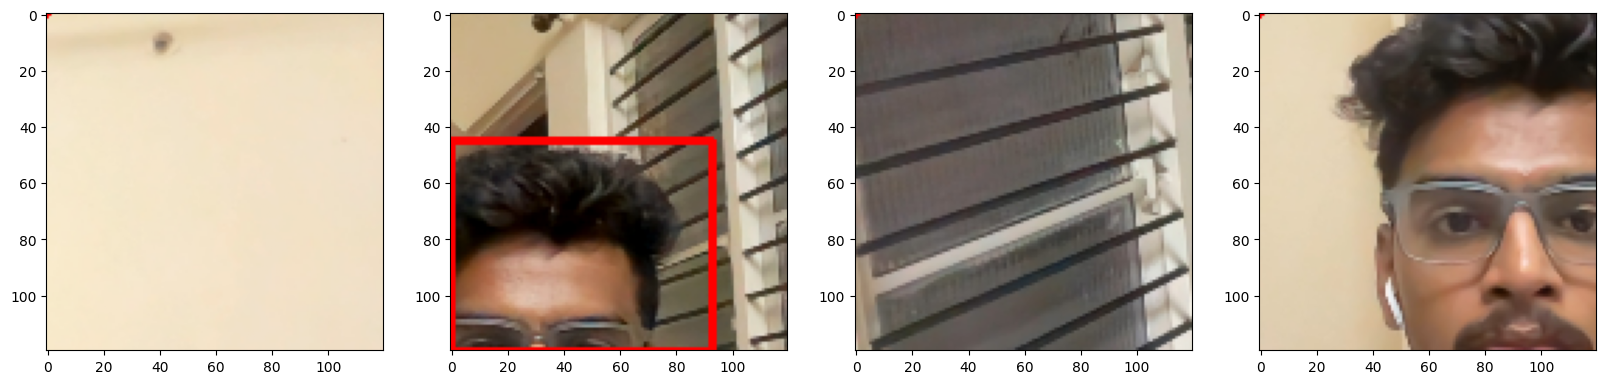

In [63]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Building the Deep Learning Model

## 8.1 Import Layers and base Network

In [64]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D,Input,MaxPooling2D,Dense,GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

## 8.2 Download VGG

In [65]:
vgg = VGG16(include_top=False)

In [66]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

## 8.3 Build instance of Network

In [67]:
# def build_model():
#     input_layer = Input(shape=(120,120,3))
#     vgg = VGG16(include_top=False)(input_layer)
    
#     #Classification Model
#     f1 = GlobalMaxPooling2D()(vgg)
#     class1 = Dense(2048,activation = 'relu')(f1)
#     class2 = Dense(1,activation = 'sigmoid')(class1)
    
    
#     f2 = GlobalMaxPooling2D()(vgg)
#     regress1 = Dense(2048,activation='relu')(f2)
#     regress2 = Dense(1,activation='sigmoid')(regress1)
#     facetracker = Model(inputs = input_layer,outputs = [class2,regress2])
#     return facetracker
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [68]:
facetracker = build_model()

In [69]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 512)                  0         ['vgg16[0][0]']               
 alMaxPooling2D)                                                                                  
                                                                                              

In [70]:
X,y = train.as_numpy_iterator().next()

In [71]:
X

array([[[[0.8509191 , 0.84797794, 0.7867034 ],
         [0.85490197, 0.84705883, 0.7882353 ],
         [0.85490197, 0.84705883, 0.7882353 ],
         ...,
         [0.79154414, 0.8656863 , 0.84822303],
         [0.84528184, 0.9237132 , 0.90410537],
         [0.76409316, 0.825     , 0.8132353 ]],

        [[0.8547794 , 0.84656864, 0.79264706],
         [0.85490197, 0.84705883, 0.7882353 ],
         [0.85447305, 0.8466299 , 0.7878064 ],
         ...,
         [0.87487745, 0.9533088 , 0.933701  ],
         [0.8637255 , 0.94215685, 0.922549  ],
         [0.73645836, 0.8076593 , 0.78382355]],

        [[0.847549  , 0.84656864, 0.79178923],
         [0.8480392 , 0.84705883, 0.7908088 ],
         [0.8509804 , 0.84656864, 0.777451  ],
         ...,
         [0.85588235, 0.9264706 , 0.9107843 ],
         [0.83596814, 0.9143995 , 0.89479166],
         [0.738174  , 0.81807595, 0.7920956 ]],

        ...,

        [[0.04785539, 0.11029412, 0.11121324],
         [0.04846814, 0.10974265, 0.1101103 ]

In [72]:
y

(array([[1],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [1]], dtype=uint8),
 array([[0.    , 0.7944, 0.4148, 1.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.291 , 0.9946, 1.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.8677, 0.496 , 1.    , 1.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.676 , 0.234 , 1.    , 1.    ]], dtype=float16))

In [73]:
X.shape

(8, 120, 120, 3)

In [74]:
classes,coords = facetracker.predict(X)

1/1 [==============================] - 0s 263ms/step


In [75]:
classes,coords

(array([[0.5811347 ],
        [0.5778033 ],
        [0.54022133],
        [0.5454647 ],
        [0.5485717 ],
        [0.5862797 ],
        [0.62802106],
        [0.53062713]], dtype=float32),
 array([[0.37488687, 0.46708184, 0.57747024, 0.48683414],
        [0.30948097, 0.51896644, 0.64444023, 0.60758746],
        [0.2743636 , 0.49231568, 0.6854714 , 0.5242392 ],
        [0.37438658, 0.43722492, 0.55477846, 0.42583418],
        [0.39429852, 0.3864636 , 0.58245254, 0.46483606],
        [0.4035197 , 0.45875317, 0.5924862 , 0.44756907],
        [0.37327275, 0.44528958, 0.59019524, 0.45412433],
        [0.37710044, 0.5007953 , 0.65284115, 0.4685372 ]], dtype=float32))

# 9. Define Losses and Optimizers

## 9.1 Define Optimizer and LR

In [76]:
len(train)

660

In [77]:
batches_per_epoch = len(train)
lr_decay = (1.0/0.75 - 1)/batches_per_epoch
lr_decay

0.0005050505050505049

In [78]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001,decay = lr_decay)

In [79]:
def localization_loss(y_true, yhat): 
    #yhat = tf.reshape(yhat,(1,8))  
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
               
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [80]:
class_loss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

## 9.3 Tesstout Loss Metrics

In [81]:
ytrue = y[1]
yhat = coords
#yhat_reshaped = tf.reshape(yhat,(-1,8))
loss = localization_loss(ytrue,yhat).numpy()
loss

4.1077356

In [82]:
class_loss(y[0],classes).numpy()

0.72015274

# 10. Train Neural Network

In [83]:
 class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [84]:
model = FaceTracker(facetracker)

In [85]:
model.compile(opt,class_loss,regressloss)

## 10.2 Train

In [101]:
logdir = 'logs2'

In [102]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [103]:
hist = model.fit(train,epochs=10,validation_data=val,callbacks=[tensorboard_callback])

Epoch 1/10
660/660 [==============================] - 83s 115ms/step - total_loss: 1.6047 - class_loss: 0.4241 - regress_loss: 1.3926 - val_total_loss: 1.9576 - val_class_loss: 0.5318 - val_regress_loss: 1.6917
Epoch 2/10
660/660 [==============================] - 75s 103ms/step - total_loss: 1.3202 - class_loss: 0.3613 - regress_loss: 1.1395 - val_total_loss: 0.4365 - val_class_loss: 0.1426 - val_regress_loss: 0.3652
Epoch 3/10
660/660 [==============================] - 70s 96ms/step - total_loss: 1.1101 - class_loss: 0.3097 - regress_loss: 0.9553 - val_total_loss: 0.3774 - val_class_loss: 0.3724 - val_regress_loss: 0.1912
Epoch 4/10
660/660 [==============================] - 69s 96ms/step - total_loss: 0.8743 - class_loss: 0.2542 - regress_loss: 0.7472 - val_total_loss: 0.0200 - val_class_loss: 0.0297 - val_regress_loss: 0.0052
Epoch 5/10
660/660 [==============================] - 69s 96ms/step - total_loss: 0.7154 - class_loss: 0.2113 - regress_loss: 0.6097 - val_total_loss: 0.7236 

In [104]:
hist.history

{'total_loss': [1.4266937971115112,
  0.9748985171318054,
  2.933464288711548,
  3.1910085678100586,
  0.6159800291061401,
  1.1675115823745728,
  0.17459000647068024,
  0.08469932526350021,
  0.1439022719860077,
  0.19523824751377106],
 'class_loss': [0.3772259056568146,
  0.29072320461273193,
  0.5406922101974487,
  0.9005017280578613,
  0.15384837985038757,
  0.388244092464447,
  0.07626929879188538,
  0.015104931779205799,
  0.03200777620077133,
  0.06039395183324814],
 'regress_loss': [1.2380808591842651,
  0.8295369148254395,
  2.6631181240081787,
  2.740757703781128,
  0.5390558242797852,
  0.9733895659446716,
  0.13645535707473755,
  0.07714685797691345,
  0.12789838016033173,
  0.1650412678718567],
 'val_total_loss': [1.9576148986816406,
  0.4364545941352844,
  0.377422571182251,
  0.020025111734867096,
  0.7235592603683472,
  0.19792558252811432,
  2.102738618850708,
  0.5782590508460999,
  1.5940296649932861,
  0.9141491651535034],
 'val_class_loss': [0.5317938327789307,
  0

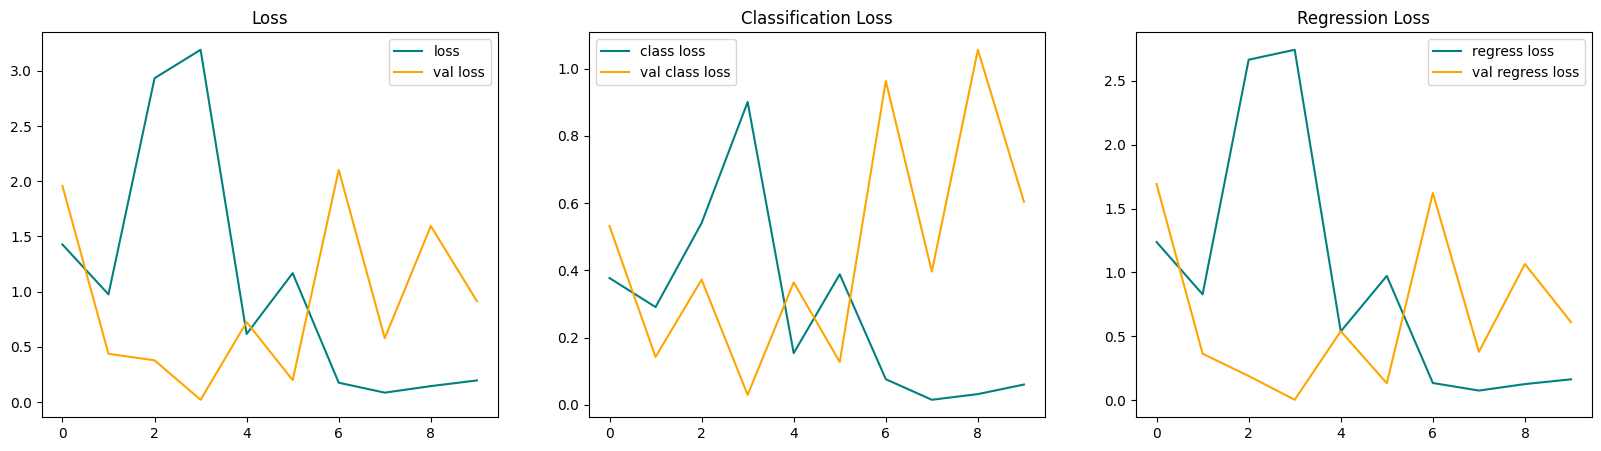

In [105]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

## 11.1 Make Predictions on the Test set

In [106]:
test_data = test.as_numpy_iterator()

In [119]:
test_sample =test_data.next()

In [120]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 22ms/step


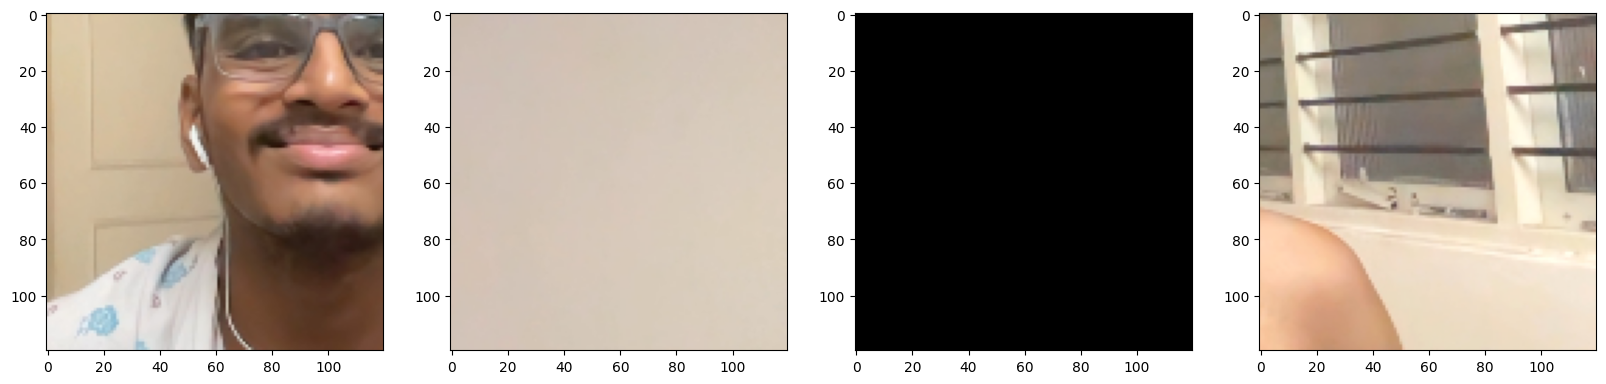

In [121]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

## 11.2 Save the Model


In [110]:
from tensorflow.keras.models import load_model
facetracker.save('facetracker2.h5')


In [111]:
facetracker = load_model('facetracker2.h5')

## 11.3 Real Time Detection

In [124]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:1920, 50:1920,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    predictor = build_model()
    predictor.load_weights('facetracker.h5')
    yhat = predictor.predict(np.expand_dims(resized/255,0))
    #yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 213ms/step


KeyboardInterrupt: 

In [123]:
! tensorboard --logdir logs2/ --port 8000


Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.13.0 at http://localhost:8000/ (Press CTRL+C to quit)
^C


In [ ]:
tensorboard_callback